# Classifying pokemons
This notebook roughly follows the fastai practical deep learning course, while aggregating some information from the different notebooks in the course.
Download the Pokemon data from https://www.kaggle.com/thedagger/pokemon-generation-one and extract it to `data/`

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai import vision # no import * because ¯\_(ツ)_/¯
import os

In [2]:
bs = 64 # set batch size
path = vision.Path('data/') # fastai path has some nice wrappers for the pathlib

## Cleanup data
Delete all image files which are no .png, .jpg or .jpeg (e.g. svg). Since we do heavy data augmentation we can handle losing some data points.

In [15]:
# delete all files with unsuitable file ending; this cell is idempotent
for r, d, f in os.walk(path):
    for file in f:
        ending = file.rsplit('.')[-1]
        if ending not in ['jpg', 'jpeg', 'png', 'JPG', 'PNG']:
            rel_path = os.path.join(r, file)
            os.remove(rel_path)
            print(f'deleted {rel_path}')

## Generate dataset
Create a databunch from folders and set up data augmentation.
Generate a ImageList from the folder, classes are folder names. And split using the same random seed, being able to accurately compare models.

In [16]:
src = vision.ImageList.from_folder(path/'train').split_by_rand_pct(0.2, seed=2)

Choose data augmentation transforms to be applied to the images on loading into the batch.

In [17]:
tfms = vision.get_transforms(max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4,
                      p_affine=1., p_lighting=1.)

In [18]:
def get_data(size, bs, padding_mode='reflection'):
    return (src.label_from_re(r'data/train/(\w*)/\w*.\w*')
           .transform(tfms, size=size, padding_mode=padding_mode)
           .databunch(bs=bs).normalize(vision.imagenet_stats))

In [19]:
data = get_data(224, bs, "zeros")

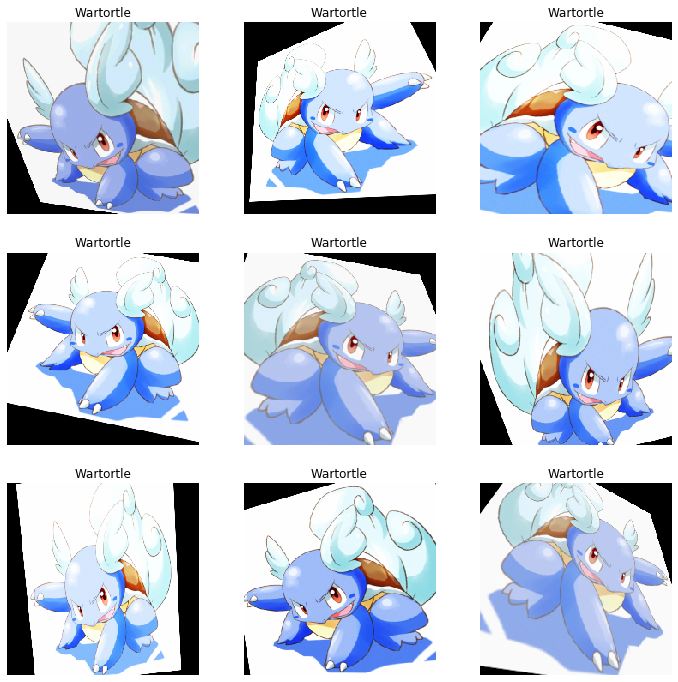

In [20]:
def _plot(i,j,ax):
    x,y = data.train_ds[8250]
    x.show(ax, y=y)

vision.plot_multi(_plot, 3, 3, figsize=(12,12))

In [23]:
learn = vision.cnn_learner(data, vision.models.resnet50, metrics=[vision.error_rate, vision.accuracy], bn_final=True)
vision.gc.collect()

4385

In [25]:
learn.unfreeze()
learn.fit_one_cycle(10, max_lr=slice(1e-5,1e-3), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,2.660510,2.946402,0.574613,0.425387,02:12
1,2.653994,2.937046,0.574378,0.425622,02:13


KeyboardInterrupt: 